In [2]:
import os, time
import numpy as np
import torch.utils.data
import torch
import torch.nn as nn
import pandas as pd

from FOS_dataset import FOS_set, transform

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\36394\anaconda3\envs\art_med\lib\site-packages\torchvision\transforms\_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
C:\Users\36394\anaconda3\envs\art_med\lib\site-packages\torchvision\transforms\_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(
C:\Users\36394\anaconda3\envs\art_med\lib\site-packages\torchvision\transforms\functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


## Test the model

In [3]:
device = torch.device('cuda')

# Load the model
model = torch.hub.load("facebookresearch/pytorchvideo", model="slowfast_r50", pretrained=True)
model.blocks[6].proj = nn.Sequential(
        nn.Linear(in_features=2304, out_features=400),
        nn.ReLU(),
        nn.Linear(in_features=400, out_features=3)
    )
# model = nn.DataParallel(model).to(device)
model = model.to(device)
model.load_state_dict(torch.load(r'best_cv_model_balanced.pt'))

Using cache found in C:\Users\36394/.cache\torch\hub\facebookresearch_pytorchvideo_main


<All keys matched successfully>

In [10]:
# Define batch size
batch_size = 8

# Define dataset
vision_classes = ['C+', 'PN', 'EA']
df_val_set = pd.read_csv(r"C:\Users\36394\PycharmProjects\care_autism_children\resnet3d\val.csv")
val_set = FOS_set(df_val_set, list_caring_labels=vision_classes, transform=transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

# model = model.cuda()
model.eval()


# Confusion matrix
y_true = []
y_pred = []
total_outputs = []
i = 0
for inputs, labels in val_loader:
    inputs = [i.to(device) for i in inputs]
    labels = labels.to(device)
    outputs = model(inputs)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(torch.where(outputs.sigmoid() > 0.5, 1.0, 0.0).cpu().numpy())
    total_outputs.extend(outputs.detach().cpu().numpy())
    if i % 100 == 0:
        print(f'Batch {i+1}/{len(val_loader)}')
    i+=1

# cm = confusion_matrix(y_true, y_pred)
# print(cm)

Batch 1/200
Batch 101/200


In [32]:
predictions = np.array(y_pred)
GTs = np.array(y_true)
probs = torch.tensor(np.array(total_outputs)).sigmoid()

In [75]:
from sklearn.metrics import multilabel_confusion_matrix, f1_score
def calculate_metrics(y_true, y_pred):

    multilabel_cm = multilabel_confusion_matrix(y_true, y_pred)

    TP = np.diag(multilabel_cm[:,:,1])
    TN = np.diag(multilabel_cm[:,:,0])
    FP = multilabel_cm[:,1,0]
    FN = multilabel_cm[:,0,1]

    f1 = f1_score(y_true, y_pred, average='weighted')

    print("F1-score:", f1)

    return f1, TP, TN, FP, FN




In [85]:
from sklearn.metrics import precision_score, recall_score
threshold = 0.33
predictions = torch.where(probs > threshold, 1.0, 0.0).cpu().numpy()
print("Confusion Matrix:")
print(multilabel_confusion_matrix(GTs, predictions))
print("Other indicator")
calculate_metrics(GTs, predictions)
print("Accuracy: {}".format(np.sum(predictions == GTs)/GTs.size))
precision = precision_score(GTs, predictions, average='weighted')
recall = recall_score(GTs, predictions, average='weighted')
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))

Confusion Matrix:
[[[1312   22]
  [ 259    5]]

 [[1593    0]
  [   5    0]]

 [[  22  961]
  [   4  611]]]
Other indicator
F1-score: 0.3989901374960783
Accuracy: 0.7390488110137672
Precision: 0.3257071814828887
Recall: 0.6968325791855203


C:\Users\36394\anaconda3\envs\art_med\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


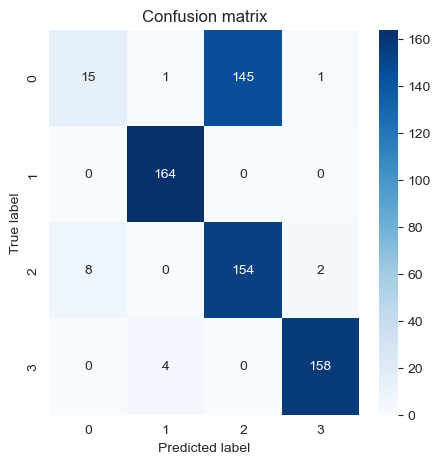

In [5]:
# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()